In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss, accuracy_score, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
sns.set()

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


## 标签编码

In [4]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)

In [5]:
print(train[:10]['author'].to_numpy())
print(y[:10])

['EAP' 'HPL' 'EAP' 'MWS' 'HPL' 'MWS' 'EAP' 'EAP' 'EAP' 'MWS']
[0 1 0 2 1 2 0 0 0 2]


In [6]:
print(lbl_enc.classes_)

['EAP' 'HPL' 'MWS']


## 训练样本拆分

<IPython.core.display.Javascript object>


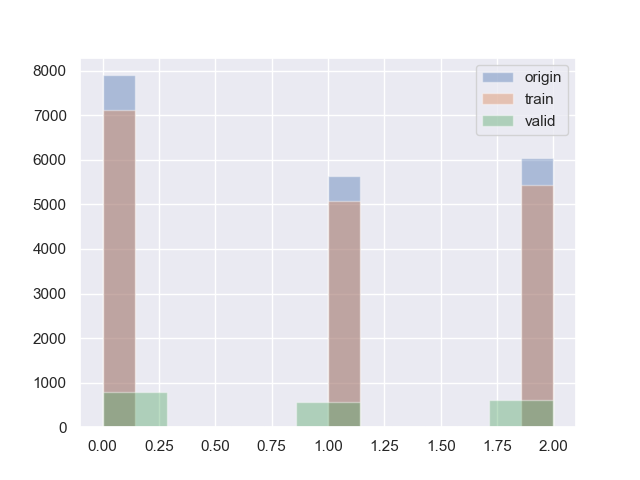

origin: [0.40349354 0.28780837 0.30869809]
train: [0.40349583 0.28778162 0.30872255]
valid: [0.40347293 0.28804903 0.30847804]


In [7]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
sns.distplot(y, label='origin', kde=False, norm_hist=False)
sns.distplot(ytrain, label='train', kde=False, norm_hist=False)
sns.distplot(yvalid, label='valid', kde=False, norm_hist=False)
plt.legend()
print('origin:', np.bincount(y)/len(y))
print('train:', np.bincount(ytrain)/len(ytrain))
print('valid:', np.bincount(yvalid)/len(yvalid))

## 特征提取

In [8]:
ctv = CountVectorizer(
    analyzer='word',token_pattern=r'\w{1,}',
    ngram_range=(1, 3), stop_words = 'english'
)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [9]:
print(xtrain[0])
print(xtrain_ctv[0].nonzero())

Her hair was the brightest living gold, and despite the poverty of her clothing, seemed to set a crown of distinction on her head.
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), array([ 38996,  39003,  39004,  56419,  56435,  56436,  71852,  71857,
        71858,  84859,  84925,  84926,  92662,  92677, 146831, 146842,
       146843, 153806, 153829, 153830, 158208, 203649, 203713, 203714,
       266371, 266382, 266383, 312719, 312787, 312788]))


In [10]:
features = np.array(ctv.get_feature_names())

In [11]:
print(features[xtrain_ctv[0].nonzero()[1]])

['brightest' 'brightest living' 'brightest living gold' 'clothing'
 'clothing set' 'clothing set crown' 'crown' 'crown distinction'
 'crown distinction head' 'despite' 'despite poverty'
 'despite poverty clothing' 'distinction' 'distinction head' 'gold'
 'gold despite' 'gold despite poverty' 'hair' 'hair brightest'
 'hair brightest living' 'head' 'living' 'living gold'
 'living gold despite' 'poverty' 'poverty clothing' 'poverty clothing set'
 'set' 'set crown' 'set crown distinction']


## 训练逻辑回归模型

In [12]:
clf = LogisticRegression(C=2.7825594, max_iter=1000)
clf.fit(xtrain_ctv, ytrain)

LogisticRegression(C=2.7825594, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
predictions = clf.predict_proba(xtrain_ctv)
print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))

predictions = clf.predict_proba(xvalid_ctv)
print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))

train set: logloss: 0.040
valid set: logloss: 0.532


In [14]:
predictions = clf.predict(xtrain_ctv)
print('train set')
print(classification_report(ytrain, predictions))

print('-' * 70)
predictions = clf.predict(xvalid_ctv)
print('validate set')
print(classification_report(yvalid, predictions))

train set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7110
           1       1.00      1.00      1.00      5071
           2       1.00      1.00      1.00      5440

    accuracy                           1.00     17621
   macro avg       1.00      1.00      1.00     17621
weighted avg       1.00      1.00      1.00     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       790
           1       0.84      0.71      0.77       564
           2       0.79      0.74      0.76       604

    accuracy                           0.77      1958
   macro avg       0.79      0.77      0.77      1958
weighted avg       0.78      0.77      0.77      1958

